In [1]:
import torch
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np
import matplotlib.pyplot as plt

import dataset
import models

import pytorch_lightning as pl

from torch.utils.data import DataLoader
from torchvision import transforms


In [2]:
scaler = RobustScaler()
composed = transforms.Compose([dataset.transforms.RandomPadding(10, 2)])

train = dataset.TraceDataset('C:/Workspace/CPA/data/method2/train', trace_size=35000, scaler=scaler, transform=composed)
test = dataset.TraceDataset('C:/Workspace/CPA/data/method2/test', trace_size=35000, scaler=scaler)

train_loader = DataLoader(train, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True, pin_memory=True)

In [3]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    check_finite=True
)

checkpoint = ModelCheckpoint(
    monitor='val_loss',
    filename='./model/checkpoints_{epoch:d}',
    verbose=True,
    save_last=True,
    save_top_k=2,
    mode='min'
)

logger = TensorBoardLogger('tb_logs', name=f'test', log_graph=True)

net = models.CNNModel(learning_rate=2e-4, weight_decay=1e-5)
#net.load_state_dict(torch.load('./model/Model.params'))

In [4]:
trainer = pl.Trainer(max_epochs=50, gpus=1, callbacks=[early_stopping, checkpoint], logger=logger)
trainer.fit(net, train_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\TecGun\anaconda3\envs\CPA\lib\site-packages\pytorch_lightning\loggers\tensorboard.py:233: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  rank_zero_warn(

  | Name        | Type             | Params
-------------------------------------------------
0 | criterion   | CrossEntropyLoss | 0     
1 | sparse_conv | Sequential       | 490   
2 | dense_conv  | Sequential       | 1.9 K 
3 | fc          | Sequential       | 17.0 M
-------------------------------------------------
17.0 M    Trainable params
0         Non-trainable params
17.0 M    Total params
68.172    Total estimated model params size (MB)


C:\Users\TecGun\anaconda3\envs\CPA\lib\site-packages\pytorch_lightning\trainer\data_loading.py:376: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\TecGun\anaconda3\envs\CPA\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\TecGun\anaconda3\envs\CPA\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
C:\Users\TecGun\anaconda3\envs\CPA\lib\site-packages\pytorch_lightning\trainer\data_lo

C:\Users\TecGun\anaconda3\envs\CPA\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:405: LightningDeprecationWarning: One of the returned values {'log', 'total', 'correct'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  warning_cache.deprecation(


Epoch 0, global step 559: val_loss reached 5.54529 (best 5.54529), saving model to "tb_logs\test\version_27\checkpoints\./model/checkpoints_epoch=0.ckpt" as top 2


Epoch 1, global step 1119: val_loss reached 5.54529 (best 5.54529), saving model to "tb_logs\test\version_27\checkpoints\./model/checkpoints_epoch=1.ckpt" as top 2


Epoch 2, global step 1679: val_loss was not in top 2


Epoch 3, global step 2239: val_loss was not in top 2


Epoch 4, global step 2799: val_loss was not in top 2


Epoch 5, global step 3359: val_loss was not in top 2


Epoch 6, global step 3919: val_loss was not in top 2


Epoch 7, global step 4479: val_loss was not in top 2


Epoch 8, global step 5039: val_loss was not in top 2


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 8960000 bytes.

In [5]:
#net = models.TestTransformerModel(learning_rate=1e-4, weight_decay=1e-5)
trace, key = next(iter(test_loader))
res = net.forward(trace)
res.shape

torch.Size([64, 256])

In [5]:
torch.save(net.state_dict(), './model/Model_finetuned.params')

In [15]:
from pytorch_lightning.metrics.functional import accuracy
import numpy as np

confusion_matrix = np.zeros((256, 256))

for _ in range(100):
    trace, key = next(iter(train_loader))

    res = net.forward(trace)
    idx = torch.argmax(res, dim=1)

    confusion_matrix[idx][key] += 1

    # res = net.forward(feat[0])
    # print(accuracy(res, feat[1]))
    # print(torch.argmax(res, dim=1))
    # print(feat[1])

import matplotlib.pyplot as plt

plt.imshow(confusion_matrix)

NameError: name 'train_loader' is not defined

In [12]:
torch.save(net.state_dict(), './model/TestCNN.params')

In [2]:
net = models.TestCNNModel(learning_rate=5e-5, weight_decay=1e-5)
net.load_state_dict(torch.load('./model/TestCNN.params'))
net.eval()

TestCNNModel(
  (criterion): CrossEntropyLoss()
  (conv): Sequential(
    (0): Conv1d(1, 2, kernel_size=(11,), stride=(4,), padding=(1,), bias=False)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(2, 4, kernel_size=(11,), stride=(4,), padding=(1,), bias=False)
    (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(4, 8, kernel_size=(11,), stride=(4,), padding=(1,), bias=False)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(8, 16, kernel_size=(11,), stride=(4,), padding=(1,), bias=False)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (fc): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1024)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=16384, out_features=1024, bias=True)
    (3): ReLU(

In [8]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    check_finite=True
)

logger = TensorBoardLogger('tb_logs', name=f'fine_tuning', log_graph=True, default_hp_metric=True)

test = dataset.TraceDataset('./data/method2/test/', trace_size=35000, scaler=StandardScaler())
test_loader = DataLoader(test, batch_size=32, shuffle=True)
train = dataset.TraceDataset('./data/method2/train/', trace_size=35000, scaler=StandardScaler())
train_loader = DataLoader(train, batch_size=32, shuffle=True, pin_memory=True)

trainer = pl.Trainer(max_epochs=30, gpus=1, callbacks=[early_stopping], logger=logger)
trainer.fit(net, train_loader, test_loader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KeyboardInterrupt: 

In [29]:
test = dataset.TraceDataset('././data/method2/test', trace_size=35000, scaler=StandardScaler())
test_loader = DataLoader(test, batch_size=16, shuffle=True)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams['lines.linewidth'] = 0.3
# plt.rcParams['text.color'] = 'white'
# plt.rcParams['ytick.color'] = 'white'
# plt.rcParams['axes.labelcolor'] = 'white'
# plt.rcParams['xtick.color'] = 'white'

softmax = nn.Softmax(dim=1)

corr: tensor([136])
pred: tensor([136])


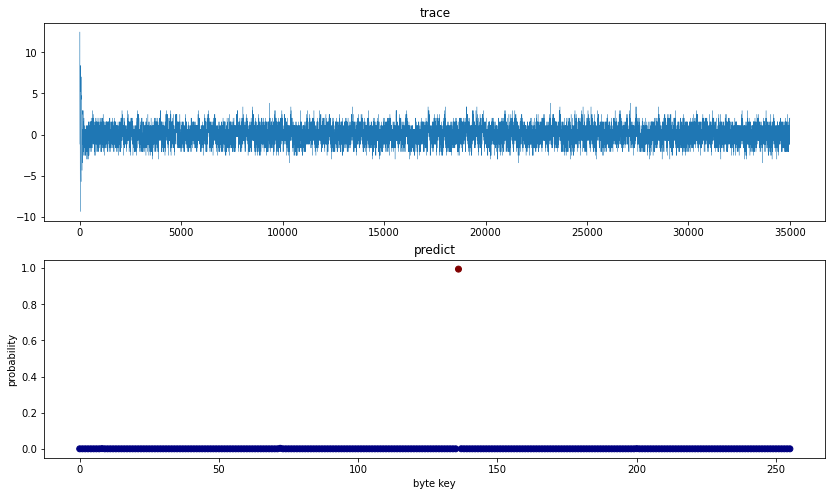

In [5]:
feat = next(iter(test_loader))

res = net.forward(feat[0])
res = softmax(res)

pred = torch.argmax(res, dim=1)

print(f'corr: {feat[1]}')
print(f'pred: {pred}')

res_np = res.squeeze().detach().numpy()

plt.subplot(211)
plt.title('trace')
plt.plot(feat[0].squeeze().detach().numpy())

plt.subplot(212)
plt.title('predict')
plt.xlabel('byte key'), plt.ylabel('probability')
plt.scatter(range(256), res_np, c=res_np, cmap='jet')

plt.show()

## Test set Confusion matrix

In [ ]:
confusion_matrix = np.zeros((256, 256), dtype=np.uint8)

for trace, key in iter(test_loader):
    res = net.forward(trace)
    idx = torch.argmax(res, dim=1).detach()

    for x, y in zip(idx, key):
        confusion_matrix[x][y] += 1

plt.title('Confusion Matrix')
plt.imshow(confusion_matrix, cmap='hot')

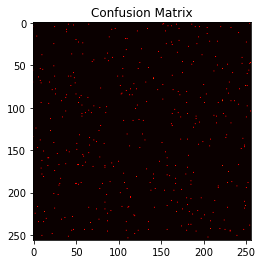

In [14]:
confusion_matrix = np.zeros((256, 256), dtype=np.uint8)

for _ in range(3):
    trace, key = next(iter(train_loader))
    res = net.forward(trace)
    idx = torch.argmax(res, dim=1).detach()

    for x, y in zip(idx, key):
        confusion_matrix[x][y] += 1

plt.title('Confusion Matrix')
plt.imshow(confusion_matrix, cmap='hot')